##데이터 불러오기

In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from lightgbm import LGBMRegressor

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cus = pd.read_csv("/content/drive/MyDrive/공모전/주식 보유 기간 예측/cus_info.csv")
iem = pd.read_csv("/content/drive/MyDrive/공모전/주식 보유 기간 예측/iem_info_20210902.csv")
hist = pd.read_csv("/content/drive/MyDrive/공모전/주식 보유 기간 예측/stk_bnc_hist.csv")
train = pd.read_csv("/content/drive/MyDrive/공모전/주식 보유 기간 예측/stk_hld_train.csv")
test = pd.read_csv("/content/drive/MyDrive/공모전/주식 보유 기간 예측/stk_hld_test.csv")

## 데이터 병합

In [ ]:
# train과 test에 고객정보(cus_info)와 주식정보(iem_info)를 추가
train_data = pd.merge(train, cus, how = "left", on = ["act_id"])
train_data = pd.merge(train_data, iem, how = "left", on = ["iem_cd"])

test_data = pd.merge(test, cus, how = "left", on = ["act_id"])
test_data = pd.merge(test_data, iem, how = "left", on = ["iem_cd"])

In [ ]:
hist["stk_p"] = hist["tot_aet_amt"] / hist["bnc_qty"] #구매 가격 feature 추가
hist = hist.fillna(0)

In [ ]:
train_data = pd.merge(train_data, hist, how = "left", on = ["act_id","iem_cd"])
train_data = train_data[(train_data["byn_dt"] == train_data["bse_dt"])]
train_data.reset_index(drop = True, inplace = True)

test_data = pd.merge(test_data, hist, how = "left", on = ["act_id", "iem_cd"])
test_data = test_data[(test_data["byn_dt"] == test_data["bse_dt"])]
test_data.reset_index(drop = True, inplace = True)

In [ ]:
#주식 명 숫자로 변환
L_encoder = LabelEncoder()
L_encoder.fit(iem["iem_krl_nm"])
train_data["iem_krl_nm"] = L_encoder.transform(train_data["iem_krl_nm"])
test_data["iem_krl_nm"] = L_encoder.transform(test_data["iem_krl_nm"])

#고객 id 숫자로 변환
L_encoder = LabelEncoder()
L_encoder.fit(cus["act_id"])
train_data["act_id"] = L_encoder.transform(train_data["act_id"])
test_data["act_id"] = L_encoder.transform(test_data["act_id"])

In [ ]:
train_data.reset_index(drop = True, inplace=True)

In [ ]:
train_data

,act_id,iem_cd,byn_dt,hold_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,bse_dt,bnc_qty,tot_aet_amt,stk_par_pr,stk_p
0,399,A006360,20180726,11,1,9,3,2,2,9,5,5,8,101,1,1,1,20180726,274.0,11782000.0,5000.0,43000.0
1,399,A005930,20180131,80,1,9,3,2,2,9,5,5,8,1361,9,1,1,20180131,2.0,4990000.0,5000.0,2495000.0
2,399,A005070,20180517,5,1,9,3,2,2,9,5,5,8,2530,12,2,99,20180517,786.0,14619600.0,1000.0,18600.0
3,399,A003520,20201112,22,1,9,3,2,2,9,5,5,8,1969,8,2,1,20201112,60.0,462000.0,500.0,7700.0
4,399,A002310,20180905,324,1,9,3,2,2,9,5,5,8,1696,10,3,99,20180905,183.0,8125200.0,5000.0,44400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681467,2678,A260660,20180831,1,1,4,4,2,2,3,4,3,8,1752,10,3,99,20180831,199.0,3532250.0,500.0,17750.0
681468,2678,A271980,20201027,1,1,4,4,2,2,3,4,3,8,2344,8,2,99,20201027,488.0,22960400.0,500.0,47050.0
681469,2678,A289080,20181121,1,1,4,4,2,2,3,4,3,8,521,2,2,99,20181121,2210.0,9204650.0,500.0,4165.0
681470,2678,A307930,20200214,1,1,4,4,2,2,3,4,3,8,2460,2,3,99,20200214,285.0,2721750.0,500.0,9550.0


# 공휴일 데이터 캘린더 처리

In [ ]:
import re
import requests
import urllib
from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday

results = {}  # {year: holidays_of_the_year_in_csv_format}

In [ ]:
#출처 : http://open.krx.co.kr/contents/MKD/01/0110/01100305/MKD01100305.jsp

class Stock_Calendar(AbstractHolidayCalendar):
    rules = [
      Holiday('2016_신정', year=2016, month=1, day=1),
      Holiday('2016_설날1', year=2016, month=2, day=8),
      Holiday('2016_설날2', year=2016, month=2, day=9),
      Holiday('2016_설날3', year=2016, month=2, day=10),
      Holiday('2016_삼일절', year=2016, month=3, day=1),
      Holiday('2016_국회의원_선거', year=2016, month=4, day=13),
      Holiday('2016_어린이날', year=2016, month=5, day=5),
      Holiday('2016_어린이날_대체공휴일', year=2016, month=5, day=6),
      Holiday('2016_현충일', year=2016, month=6, day=6),
      Holiday('2016_광복절', year=2016, month=8, day=15),
      Holiday('2016_추석1', year=2016, month=9, day=14),
      Holiday('2016_추석2', year=2016, month=9, day=15),
      Holiday('2016_추석3', year=2016, month=9, day=16),
      Holiday('2016_개천절', year=2016, month=10, day=3),
      Holiday('2016_연말', year=2016, month=12, day=30),
      
      Holiday('2017_설날1', year=2017, month=1, day=27),
      Holiday('2017_설날_대체공휴일', year=2017, month=1, day=30),
      Holiday('2017_삼일절', year=2017, month=3, day=1),
      Holiday('2017_근로자의 날', year=2017, month=5, day=1),
      Holiday('2017_석가탄신일', year=2017, month=5, day=3),
      Holiday('2017_어린이날', year=2017, month=5, day=5),
      Holiday('2017_대통령선거일', year=2017, month=5, day=9),
      Holiday('2017_현충일', year=2017, month=6, day=6),
      Holiday('2017_광복절', year=2017, month=8, day=15),
      Holiday('2017_임시공휴일', year=2017, month=10, day=2),
      Holiday('2017_개천절', year=2017, month=10, day=3),
      Holiday('2017_추석1', year=2017, month=10, day=4),
      Holiday('2017_추석2', year=2017, month=10, day=5),
      Holiday('2017_추석_대체', year=2017, month=10, day=6),
      Holiday('2017_한글날', year=2017, month=10, day=9),
      Holiday('2017_크리스마스', year=2017, month=12, day=25),
      Holiday('2017_연말휴장일', year=2017, month=12, day=29),       

      Holiday('2018_신정', year=2018, month=1, day=1),
      Holiday('2018_설날', year=2018, month=2, day=15),
      Holiday('2018_설날2', year=2018, month=2, day=16),
      Holiday('2018_삼일절', year=2018, month=3, day=1),
      Holiday('2018_근로자의날', year=2018, month=5, day=1),
      Holiday('2018_어린이날_대체휴일', year=2018, month=5, day=7),
      Holiday('2018_석가탄신일', year=2018, month=5, day=22),
      Holiday('2018_현충일', year=2018, month=6, day=6),
      Holiday('2018_지방선거', year=2018, month=6, day=13),
      Holiday('2018_광복절', year=2018, month=8, day=15),
      Holiday('2018_추석1', year=2018, month=9, day=24),
      Holiday('2018_추석2', year=2018, month=9, day=25),
      Holiday('2018_추석_대체공휴일일', year=2018, month=9, day=26),
      Holiday('2018_개천절', year=2018, month=10, day=3),
      Holiday('2018_한글날', year=2018, month=10, day=9),
      Holiday('2018_크리스마스', year=2018, month=12, day=25),
      Holiday('2018_연말휴장일', year=2018, month=12, day=31),

      Holiday('2019_신정', year=2019, month=1, day=1),
      Holiday('2019_설날1', year=2019, month=2, day=4),
      Holiday('2019_설날2', year=2019, month=2, day=5),
      Holiday('2019_설날3', year=2019, month=2, day=6),
      Holiday('2019_삼일절', year=2019, month=3, day=1),
      Holiday('2019_근로자의날', year=2019, month=5, day=1),
      Holiday('2019_어린이날_대체휴일', year=2019, month=5, day=6),
      Holiday('2019_현충일', year=2019, month=6, day=6),
      Holiday('2019_광복절', year=2019, month=8, day=15),
      Holiday('2019_추석1', year=2019, month=9, day=12),
      Holiday('2019_추석2', year=2019, month=9, day=13),
      Holiday('2019_개천절', year=2019, month=10, day=3),
      Holiday('2019_한글날', year=2019, month=10, day=9),
      Holiday('2019_크리스마스', year=2019, month=12, day=25),
      Holiday('2019_연말휴장일', year=2019, month=12, day=31),

      Holiday('2020_신정', year=2020, month=1, day=1),
      Holiday('2020_설날', year=2020, month=1, day=24),
      Holiday('2020_설날_대체', year=2020, month=1, day=27),
      Holiday('2020_국회의원선거', year=2020, month=4, day=15),
      Holiday('2020_석가탄신일', year=2020, month=4, day=30),
      Holiday('2020_근로자의날', year=2020, month=5, day=1),
      Holiday('2020_어린이날', year=2020, month=5, day=5),
      Holiday('2020_임시공휴일', year=2020, month=8, day=17),
      Holiday('2020_추석1', year=2020, month=9, day=30),
      Holiday('2020_추석2', year=2020, month=10, day=1),
      Holiday('2020_추석3', year=2020, month=10, day=2),
      Holiday('2020_한글날', year=2020, month=10, day=9),
      Holiday('2020_크리스마스', year=2020, month=12, day=25),
      Holiday('2020_연말휴장일일', year=2020, month=12, day=31)

    ]

# hist_d 작업_new

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 681472 entries, 0 to 681471
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   act_id                681472 non-null  int64  
 1   iem_cd                681472 non-null  object 
 2   byn_dt                681472 non-null  int64  
 3   hold_d                681472 non-null  int64  
 4   sex_dit_cd            681472 non-null  int64  
 5   cus_age_stn_cd        681472 non-null  int64  
 6   ivs_icn_cd            681472 non-null  int64  
 7   cus_aet_stn_cd        681472 non-null  int64  
 8   mrz_pdt_tp_sgm_cd     681472 non-null  int64  
 9   lsg_sgm_cd            681472 non-null  int64  
 10  tco_cus_grd_cd        681472 non-null  int64  
 11  tot_ivs_te_sgm_cd     681472 non-null  int64  
 12  mrz_btp_dit_cd        681472 non-null  int64  
 13  iem_krl_nm            681472 non-null  int64  
 14  btp_cfc_cd            681472 non-null  int64  
 15  

In [ ]:
from datetime import datetime, date
from pandas.tseries.offsets import CustomBusinessDay
TDay = TradingDay = CustomBusinessDay(calendar=Stock_Calendar(AbstractHolidayCalendar)) # 공휴일을 포함한 영업일 함수 정의

In [ ]:
standard_list=[20200630,20191231,20190630,20181231,20180630,20171231,20170630,20161231,20160630]

In [ ]:
selling_list= [20201231,20200731,20191231,20190731,20181231,20180731,20171231,20170731,20161231]

In [ ]:
a_2=          [20190630,20190101,20180630,20180101,20170630,20170101,20160630,20160101,20150630]

In [ ]:
my_data=pd.DataFrame()

In [ ]:
for i, j, k in zip(standard_list, selling_list,a_2):
  standard_date=i
  selling_date=j
  start=k

  #매도 기준일
  b=pd.to_datetime(str(standard_date))
  c=pd.to_datetime(str(selling_date))

  #기준일 이전 매수 데이터만 남기기
  work_data=train_data[train_data.byn_dt<=standard_date]
  work_data=work_data[train_data.byn_dt>=start]

  #다시 datatime 형태로 전환
  work_data['byn_dt']=work_data['byn_dt'].astype(str)
  work_data['byn_dt']=pd.to_datetime(work_data['byn_dt'])

  #이제 train data에는 기준일 이전 매수 데이터만 남아있는 상태

  #주식 개장일 데이터 형태 변경 (date time 형태로)
  array_buying_date=np.array(work_data['byn_dt'])
  array_hold_d=np.array(work_data['hold_d'])

  매도일자=[]
  for i, j in zip(work_data['byn_dt'], work_data['hold_d']):
    selling_day=i + TDay*j
    매도일자.append(selling_day)

  work_data['매도일자']=매도일자
  work_data=work_data[['act_id', 'iem_cd',	'byn_dt', '매도일자','hold_d',
                       'sex_dit_cd',	'cus_age_stn_cd',	'ivs_icn_cd',	'cus_aet_stn_cd',
                       'mrz_pdt_tp_sgm_cd',	'lsg_sgm_cd',	'tco_cus_grd_cd',	'tot_ivs_te_sgm_cd',
                       'mrz_btp_dit_cd',	'iem_krl_nm',	'btp_cfc_cd',	'mkt_pr_tal_scl_tp_cd',
                       'stk_dit_cd',	'bse_dt',	'bnc_qty',	'tot_aet_amt',	'stk_par_pr',	'stk_p']]

  # 이제 train data는 6월 31일 이전에 매수한 데이터 & 매도일자 feature가 추가된 상태
  work_data['매도일자']=pd.to_datetime(work_data['매도일자'])

  #매도 기준일 범위에 맞는 데이터만 남기기
  work_data=work_data[work_data.매도일자>b]
  work_data=work_data[work_data.매도일자<=c]

  #standard_date 이전에 매수해서, { standard date ~ standard date+한달 } 사이에 매도한 데이터
  work_data = work_data.reset_index(drop=True)

  #매수일부터 기준일까지 주식 보유기간인 hist_d feature 제작
  new_hist_d=[]
  ts_w = pd.to_datetime(str(standard_date))
  d = ts_w.strftime('%Y-%m-%d')

  for i in work_data['byn_dt']:
    ts = pd.to_datetime(str(i)) 
    day = ts.strftime('%Y-%m-%d')
    hist_day=np.busday_count(
    day, d,
    weekmask=TDay.weekmask,
    holidays=TDay.holidays
    )
    new_hist_d.append(hist_day)

  work_data['hist_d']=new_hist_d

  # 6월 30일 이전 매수 $ 7월~12월 사이에에 매도한 row만 모아놓은 train_data에서 hold_d 추가한 상태
  train=work_data

  my_data = pd.concat([my_data,train])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/usr/local

In [ ]:
my_data

,act_id,iem_cd,byn_dt,매도일자,hold_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,bse_dt,bnc_qty,tot_aet_amt,stk_par_pr,stk_p,hist_d
0,7085,A004800,2020-05-11,2020-09-04,83,1,6,0,3,2,5,5,6,9,3037,2,2,1,20200511,1.0,69400.0,5000.0,69400.0,36
1,7085,A009540,2020-06-15,2020-11-23,110,1,6,0,3,2,5,5,6,9,2848,6,1,1,20200615,4.0,345200.0,5000.0,86300.0,11
2,7085,A005160,2020-06-01,2020-07-14,31,1,6,0,3,2,5,5,6,9,974,10,3,99,20200601,25.0,66125.0,1000.0,2645.0,21
3,7085,A104460,2020-05-28,2020-08-26,63,1,6,0,3,2,5,5,6,9,1065,10,2,99,20200528,35.0,338800.0,500.0,9680.0,23
4,7085,A064960,2020-05-28,2020-08-13,55,1,6,0,3,2,5,5,6,9,509,6,2,1,20200528,2.0,77700.0,5000.0,38850.0,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,3310,A131030,2016-06-23,2016-07-08,11,1,6,0,5,2,5,3,5,2,1056,10,3,99,20160623,30.0,340500.0,500.0,11350.0,5
316,3310,A017670,2016-06-16,2016-07-11,17,1,6,0,5,2,5,3,5,2,505,4,1,1,20160616,2.0,421000.0,500.0,210500.0,10
317,3310,A009290,2016-06-10,2016-08-26,54,1,6,0,5,2,5,3,5,2,699,8,2,99,20160610,50.0,532500.0,1000.0,10650.0,14
318,2678,A034830,2016-06-30,2016-07-01,1,1,4,4,2,2,3,4,3,8,2863,2,2,99,20160630,2800.0,10444000.0,1000.0,3730.0,0


In [ ]:
train_data=my_data.sample(frac=1).reset_index(drop=True)

In [ ]:
train_data

,act_id,iem_cd,byn_dt,매도일자,hold_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,bse_dt,bnc_qty,tot_aet_amt,stk_par_pr,stk_p,hist_d
0,6620,A011170,2020-06-26,2020-07-07,7,2,5,99,2,2,5,4,3,10,1121,12,1,1,20200626,29.0,4988000.0,5000.0,172000.0,2
1,622,A026960,2019-12-24,2020-03-30,64,1,6,4,5,2,5,2,4,14,984,7,1,1,20191224,600.0,10890000.0,500.0,18150.0,4
2,9291,A040420,2019-06-07,2020-03-09,186,1,4,4,4,2,3,4,3,9,2305,5,3,99,20190607,22.0,167200.0,500.0,7600.0,141
3,872,A067290,2018-06-26,2019-05-13,214,2,5,99,1,2,5,9,3,16,141,10,2,99,20180626,30.0,246600.0,500.0,8220.0,127
4,512,A011070,2018-07-12,2019-01-28,133,2,8,3,3,2,6,4,3,13,419,9,1,1,20180712,4.0,634000.0,5000.0,158500.0,115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70280,9193,A218150,2018-10-17,2019-01-30,72,1,8,99,5,2,7,3,4,5,1216,10,3,99,20181017,20.0,83200.0,100.0,4160.0,52
70281,7297,A025320,2019-10-07,2020-01-10,65,2,9,3,3,2,9,4,3,9,1579,13,2,99,20191007,10.0,30600.0,500.0,3060.0,59
70282,9012,A000270,2020-06-25,2020-07-13,12,2,3,2,2,2,4,5,2,12,747,6,1,1,20200625,2.0,65100.0,5000.0,32550.0,3
70283,8426,A092040,2018-08-30,2019-02-11,106,1,3,4,3,2,3,4,3,10,1690,10,2,2,20180830,240.0,10572000.0,500.0,44050.0,81


# 수치형 데이터 스케일링

### 시각화

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252894 entries, 0 to 252893
Data columns (total 24 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   act_id                252894 non-null  int64         
 1   iem_cd                252894 non-null  object        
 2   byn_dt                252894 non-null  datetime64[ns]
 3   매도일자                  252894 non-null  datetime64[ns]
 4   hold_d                252894 non-null  int64         
 5   sex_dit_cd            252894 non-null  int64         
 6   cus_age_stn_cd        252894 non-null  int64         
 7   ivs_icn_cd            252894 non-null  int64         
 8   cus_aet_stn_cd        252894 non-null  int64         
 9   mrz_pdt_tp_sgm_cd     252894 non-null  int64         
 10  lsg_sgm_cd            252894 non-null  int64         
 11  tco_cus_grd_cd        252894 non-null  int64         
 12  tot_ivs_te_sgm_cd     252894 non-null  int64         
 13 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log1p
  result = 

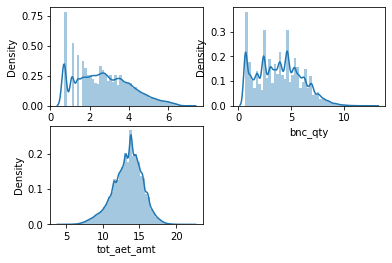

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.subplot(221)
sns.distplot(np.log1p(train_data['hist_d']))

plt.subplot(222)
sns.distplot(np.log1p(train_data['bnc_qty']))

plt.subplot(223)
sns.distplot(np.log1p(train_data['tot_aet_amt']))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = geta

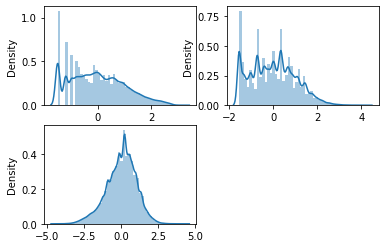

In [ ]:
import math
from sklearn import preprocessing

plt.subplot(221)
sns.distplot(preprocessing.scale(np.log(train_data["hist_d"]+1)))
plt.subplot(222)
sns.distplot(preprocessing.scale(np.log(train_data['bnc_qty']+1)))
plt.subplot(223)
sns.distplot(preprocessing.scale(np.log(train_data['tot_aet_amt']+1)))

### 수치형 변수 처리

In [ ]:
로그 변환_2 (이거 사용할 것!)

import math
from sklearn import preprocessing

need_log_features = ['tot_aet_amt','hist_d','bnc_qty','stk_par_pr','stk_p']

for i in enumerate (need_log_features) :
  ca = i[1]
  train_data[ca] = np.log1p(train_data[ca])
  test_data[ca] = np.log1p(test_data[ca])

In [ ]:
# 표준화

#from sklearn.preprocessing import StandardScaler

# StandardScaler객체 생성
#scaler = StandardScaler()

#cat_features_2 = ['수익률']

#for i in enumerate (cat_features_2) :
  #ca = i[1]
  #scaler.fit(train_data[[ca]])
  #train_data[[ca]] = scaler.transform(train_data[[ca]])
  #test_data[[ca]] = scaler.transform(test_data[[ca]])

In [ ]:
# 로그 변환 (마이너스를 잘 보존해야 할때 사용할 것)

#import math
#from sklearn import preprocessing

#need_log_features = ['tot_aet_amt','hist_d','bnc_qty','stk_par_pr','stk_p']

#for i in enumerate (need_log_features) :
  #ca = i[1]
  #train_data[ca] = preprocessing.scale(np.log(train_data[ca]+1))
  #test_data[ca] = preprocessing.scale(np.log(test_data[ca]+1))

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


# 명목형 변수 처리

In [ ]:
train_data

,act_id,iem_cd,byn_dt,매도일자,hold_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,bse_dt,bnc_qty,tot_aet_amt,stk_par_pr,stk_p,hist_d
0,5901,A018000,2020-08-26,2020-09-03,6,2,3,3,3,2,4,4,2,12,2107,10,2,2,20200826,1.0,3980.0,500.0,3980.0,4.0
1,2396,A034020,2020-08-31,2020-09-01,1,1,6,3,3,2,7,4,3,10,1033,3,1,1,20200831,113.0,1819300.0,5000.0,16100.0,1.0
2,5177,A068270,2017-10-11,2018-01-29,75,2,6,4,5,2,8,4,4,10,1528,8,1,1,20171011,30.0,4380000.0,1000.0,146000.0,56.0
3,66,A005930,2020-03-11,2020-06-01,54,1,7,3,4,2,5,3,5,9,1361,9,1,1,20200311,10.0,521000.0,100.0,52100.0,54.0
4,8443,A009810,2019-09-17,2019-12-06,56,2,1,3,2,2,2,5,3,9,1924,7,3,99,20190917,4354.0,4053574.0,500.0,931.0,52.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252889,6062,A214870,2020-08-05,2020-09-02,19,1,4,2,2,2,3,4,3,13,840,13,2,99,20200805,33.0,471900.0,500.0,14300.0,18.0
252890,1952,A012030,2020-07-31,2020-08-03,1,1,9,2,3,2,9,4,4,12,71,5,3,99,20200731,1.0,724.0,500.0,724.0,1.0
252891,3407,A093230,2019-07-26,2019-08-23,19,1,2,99,1,2,2,9,3,16,2206,7,3,99,20190726,7265.0,2651725.0,200.0,365.0,4.0
252892,45,A213420,2018-01-29,2019-07-23,362,1,5,3,4,2,5,3,4,13,954,13,1,2,20180129,347.0,6992050.0,200.0,20150.0,346.0


In [ ]:
cat_features = ['act_id','sex_dit_cd',	'ivs_icn_cd',	'mrz_pdt_tp_sgm_cd',	'lsg_sgm_cd',	'tco_cus_grd_cd',	'mrz_btp_dit_cd',	'iem_krl_nm',	'btp_cfc_cd',	'mkt_pr_tal_scl_tp_cd',	'stk_dit_cd']

for i in enumerate (cat_features) :
  ca = i[1]
  train_data[ca] = train_data[ca].astype('category')
  test_data[ca] = test_data[ca].astype('category')

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252894 entries, 0 to 252893
Data columns (total 24 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   act_id                252894 non-null  category      
 1   iem_cd                252894 non-null  object        
 2   byn_dt                252894 non-null  datetime64[ns]
 3   매도일자                  252894 non-null  datetime64[ns]
 4   hold_d                252894 non-null  int64         
 5   sex_dit_cd            252894 non-null  category      
 6   cus_age_stn_cd        252894 non-null  int64         
 7   ivs_icn_cd            252894 non-null  category      
 8   cus_aet_stn_cd        252894 non-null  int64         
 9   mrz_pdt_tp_sgm_cd     252894 non-null  category      
 10  lsg_sgm_cd            252894 non-null  category      
 11  tco_cus_grd_cd        252894 non-null  category      
 12  tot_ivs_te_sgm_cd     252894 non-null  int64         
 13 

# 모양에 맞게 변형

In [ ]:
train_data = train_data.drop(["iem_cd", "byn_dt", "bse_dt","매도일자","act_id"], axis = 1)
test_data = test_data.drop(["iem_cd", "byn_dt", "submit_id", "hold_d", "bse_dt","act_id"], axis = 1)

In [ ]:
train_data=train_data[['hold_d','hist_d','sex_dit_cd','cus_age_stn_cd','ivs_icn_cd','cus_aet_stn_cd','mrz_pdt_tp_sgm_cd','lsg_sgm_cd','tco_cus_grd_cd','tot_ivs_te_sgm_cd','mrz_btp_dit_cd','iem_krl_nm','btp_cfc_cd','mkt_pr_tal_scl_tp_cd','stk_dit_cd','bnc_qty','tot_aet_amt','stk_par_pr','stk_p']]

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252894 entries, 0 to 252893
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   hold_d                252894 non-null  int64   
 1   hist_d                252894 non-null  float64 
 2   sex_dit_cd            252894 non-null  category
 3   cus_age_stn_cd        252894 non-null  int64   
 4   ivs_icn_cd            252894 non-null  category
 5   cus_aet_stn_cd        252894 non-null  int64   
 6   mrz_pdt_tp_sgm_cd     252894 non-null  category
 7   lsg_sgm_cd            252894 non-null  category
 8   tco_cus_grd_cd        252894 non-null  category
 9   tot_ivs_te_sgm_cd     252894 non-null  int64   
 10  mrz_btp_dit_cd        252894 non-null  category
 11  iem_krl_nm            252894 non-null  category
 12  btp_cfc_cd            252894 non-null  category
 13  mkt_pr_tal_scl_tp_cd  252894 non-null  category
 14  stk_dit_cd            252894 non-nul

In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70596 entries, 0 to 70595
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   hist_d                70596 non-null  int64   
 1   sex_dit_cd            70596 non-null  category
 2   cus_age_stn_cd        70596 non-null  int64   
 3   ivs_icn_cd            70596 non-null  category
 4   cus_aet_stn_cd        70596 non-null  int64   
 5   mrz_pdt_tp_sgm_cd     70596 non-null  category
 6   lsg_sgm_cd            70596 non-null  category
 7   tco_cus_grd_cd        70596 non-null  category
 8   tot_ivs_te_sgm_cd     70596 non-null  int64   
 9   mrz_btp_dit_cd        70596 non-null  category
 10  iem_krl_nm            70596 non-null  category
 11  btp_cfc_cd            70596 non-null  category
 12  mkt_pr_tal_scl_tp_cd  70596 non-null  category
 13  stk_dit_cd            70596 non-null  category
 14  bnc_qty               70596 non-null  float64 
 15  to

In [ ]:
# train_data에서 Y값을 추출한 후 hold_d column을 삭제

train_label = train_data["hold_d"]
train_data.drop(["hold_d"], axis = 1, inplace = True)

train_label.reset_index(drop = True, inplace=True)

In [ ]:
train_data

,hist_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,bnc_qty,tot_aet_amt,stk_par_pr,stk_p
0,4.0,2,3,3,3,2,4,4,2,12,2107,10,2,2,1.0,3980.0,500.0,3980.0
1,1.0,1,6,3,3,2,7,4,3,10,1033,3,1,1,113.0,1819300.0,5000.0,16100.0
2,56.0,2,6,4,5,2,8,4,4,10,1528,8,1,1,30.0,4380000.0,1000.0,146000.0
3,54.0,1,7,3,4,2,5,3,5,9,1361,9,1,1,10.0,521000.0,100.0,52100.0
4,52.0,2,1,3,2,2,2,5,3,9,1924,7,3,99,4354.0,4053574.0,500.0,931.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252889,18.0,1,4,2,2,2,3,4,3,13,840,13,2,99,33.0,471900.0,500.0,14300.0
252890,1.0,1,9,2,3,2,9,4,4,12,71,5,3,99,1.0,724.0,500.0,724.0
252891,4.0,1,2,99,1,2,2,9,3,16,2206,7,3,99,7265.0,2651725.0,200.0,365.0
252892,346.0,1,5,3,4,2,5,3,4,13,954,13,1,2,347.0,6992050.0,200.0,20150.0


# test_data 수익률 feature와 합치기 (실행 X)

In [ ]:
cost

,iem_cd,종가_160630,종가_161229,종가_170630,종가_171228,종가_180629,종가_181228,종가_190628,종가_191230,종가_200630,종가_201230
0,A006360,27750.0,26500.0,30450.0,28300.0,46000.0,43750.0,40350.0,31050.0,24550.0,37800.0
1,A005930,1425000.0,1802000.0,2377000.0,2548000.0,46650.0,38700.0,47000.0,55800.0,52800.0,81000.0
2,A005070,2980.0,5160.0,7700.0,15450.0,21300.0,17350.0,13450.0,8900.0,12400.0,19650.0
3,A003520,11700.0,8820.0,11350.0,8780.0,7430.0,5940.0,5070.0,6630.0,5520.0,8040.0
4,A002310,20500.0,18300.0,20450.0,18200.0,34550.0,31400.0,38500.0,30000.0,29900.0,37250.0
...,...,...,...,...,...,...,...,...,...,...,...
2921,A302440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2922,A272850,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2923,A241390,9905.0,9825.0,10430.0,10575.0,10275.0,10130.0,10560.0,10615.0,10445.0,11985.0
2924,A153760,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
standard_column="종가_201230"
test_data= pd.merge(test_data, cost[["iem_cd",standard_column]], how = "left", on = ["iem_cd"])
test_data['수익률']= (test_data[standard_column] / test_data["stk_p"] - 1) * 100
test_data = test_data.drop([standard_column], axis = 1)

# 중요 Feature만 남기기 (실행 X)

In [ ]:
train_data=train_data[["act_id","iem_krl_nm","hist_d","mrz_btp_dit_cd","수익률","bnc_qty","tot_aet_amt"]]

In [ ]:
test_data=test_data[["act_id","iem_krl_nm","hist_d","mrz_btp_dit_cd","수익률","bnc_qty","tot_aet_amt"]]

# 전처리 파일 csv 형태로 다운로드

In [ ]:
train_data.to_csv("10.03_train_data.csv", index = False)
test_data.to_csv("10.03_test_data.csv", index = False)
train_label.to_csv("10.03_train_label.csv", index = False)

# 추가 전처리_원핫인코딩 (실행 X)

In [ ]:
train_data.columns.tolist()

['act_id',
 'iem_krl_nm',
 'hist_d',
 'mrz_btp_dit_cd',
 '수익률',
 'bnc_qty',
 'tot_aet_amt']

In [ ]:
list=np.array(['act_id', 'iem_krl_nm', 'mrz_btp_dit_cd'])

In [ ]:
train_data

,act_id,iem_krl_nm,hist_d,mrz_btp_dit_cd,수익률,bnc_qty,tot_aet_amt
0,4630,1816,3.332205,10,-0.237968,4.564348,-0.471137
1,5054,2261,3.258097,5,-0.017634,3.891820,0.634567
2,8540,1997,3.610918,10,1.720286,0.693147,-1.942583
3,7547,78,5.288267,14,-0.294081,5.298317,0.505622
4,3195,1677,4.234107,13,0.257363,1.386294,-1.279290
...,...,...,...,...,...,...,...
73225,2599,1969,1.945910,9,0.086032,4.615121,-0.030394
73226,5774,2039,3.610918,14,-0.073046,1.791759,-1.878010
73227,6822,2975,5.017280,6,-0.462058,4.406719,0.827359
73228,2695,1361,3.891820,7,0.305582,3.044522,0.190904


In [ ]:
for i in list:
  L_encoder.fit(train_data[i])
  train_data[i] = L_encoder.transform(train_data[i])

  for label in np.unique(test_data[i]):
    if label not in L_encoder.classes_: # unseen label 데이터인 경우( )
        L_encoder.classes_ = np.append(L_encoder.classes_, label) # 미처리 시 ValueError발생

  test_data[i] = L_encoder.transform(test_data[i])
  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
td=pd.get_dummies(train_data, columns = ['act_id', 'iem_krl_nm', 'mrz_btp_dit_cd'])

In [ ]:
ted=pd.get_dummies(test_data, columns = ['act_id', 'iem_krl_nm', 'mrz_btp_dit_cd'])

In [ ]:
td.columns.values.tolist()

['hist_d',
 '수익률',
 'bnc_qty',
 'tot_aet_amt',
 'act_id_0',
 'act_id_1',
 'act_id_2',
 'act_id_3',
 'act_id_4',
 'act_id_5',
 'act_id_6',
 'act_id_7',
 'act_id_8',
 'act_id_9',
 'act_id_10',
 'act_id_11',
 'act_id_12',
 'act_id_13',
 'act_id_14',
 'act_id_15',
 'act_id_16',
 'act_id_17',
 'act_id_18',
 'act_id_19',
 'act_id_20',
 'act_id_21',
 'act_id_22',
 'act_id_23',
 'act_id_24',
 'act_id_25',
 'act_id_26',
 'act_id_27',
 'act_id_28',
 'act_id_29',
 'act_id_30',
 'act_id_31',
 'act_id_32',
 'act_id_33',
 'act_id_34',
 'act_id_35',
 'act_id_36',
 'act_id_37',
 'act_id_38',
 'act_id_39',
 'act_id_40',
 'act_id_41',
 'act_id_42',
 'act_id_43',
 'act_id_44',
 'act_id_45',
 'act_id_46',
 'act_id_47',
 'act_id_48',
 'act_id_49',
 'act_id_50',
 'act_id_51',
 'act_id_52',
 'act_id_53',
 'act_id_54',
 'act_id_55',
 'act_id_56',
 'act_id_57',
 'act_id_58',
 'act_id_59',
 'act_id_60',
 'act_id_61',
 'act_id_62',
 'act_id_63',
 'act_id_64',
 'act_id_65',
 'act_id_66',
 'act_id_67',
 'act_id_68

In [ ]:
td_cols = td.columns.values.tolist()
ted_cols = ted.columns.values.tolist()
cols_not_in_test = {c:0 for c in td_cols if c not in ted_cols}
cols_not_in_train = {c:0 for c in ted_cols if c not in td_cols}
ted = ted.assign(**cols_not_in_test)
td= td.assign(**cols_not_in_train)

In [ ]:
train_data=td

In [ ]:
test_data=ted

In [ ]:
train_data

,hist_d,수익률,bnc_qty,tot_aet_amt,act_id_0,act_id_1,act_id_2,act_id_3,act_id_4,act_id_5,act_id_6,act_id_7,act_id_8,act_id_9,act_id_10,act_id_11,act_id_12,act_id_13,act_id_14,act_id_15,act_id_16,act_id_17,act_id_18,act_id_19,act_id_20,act_id_21,act_id_22,act_id_23,act_id_24,act_id_25,act_id_26,act_id_27,act_id_28,act_id_29,act_id_30,act_id_31,act_id_32,act_id_33,act_id_34,act_id_35,...,act_id_9970,act_id_9971,act_id_9972,act_id_9973,act_id_9974,act_id_9975,act_id_9976,act_id_9977,act_id_9978,act_id_9979,act_id_9980,act_id_9981,act_id_9982,act_id_9983,act_id_9984,act_id_9985,act_id_9986,act_id_9987,act_id_9988,act_id_9989,iem_krl_nm_2810,iem_krl_nm_2811,iem_krl_nm_2812,iem_krl_nm_2815,iem_krl_nm_2816,iem_krl_nm_2817,iem_krl_nm_2818,iem_krl_nm_2819,iem_krl_nm_2820,iem_krl_nm_2821,iem_krl_nm_2822,iem_krl_nm_2823,iem_krl_nm_2824,iem_krl_nm_2825,iem_krl_nm_2826,iem_krl_nm_2827,iem_krl_nm_2829,iem_krl_nm_2830,iem_krl_nm_2831,iem_krl_nm_2832
0,3.332205,-0.237968,4.564348,-0.471137,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3.258097,-0.017634,3.891820,0.634567,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3.610918,1.720286,0.693147,-1.942583,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,5.288267,-0.294081,5.298317,0.505622,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4.234107,0.257363,1.386294,-1.279290,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73225,1.945910,0.086032,4.615121,-0.030394,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
73226,3.610918,-0.073046,1.791759,-1.878010,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
73227,5.017280,-0.462058,4.406719,0.827359,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
73228,3.891820,0.305582,3.044522,0.190904,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
test_data

,hist_d,수익률,bnc_qty,tot_aet_amt,act_id_0,act_id_1,act_id_2,act_id_3,act_id_4,act_id_5,act_id_6,act_id_7,act_id_8,act_id_9,act_id_10,act_id_11,act_id_12,act_id_13,act_id_14,act_id_15,act_id_16,act_id_17,act_id_18,act_id_19,act_id_20,act_id_21,act_id_22,act_id_23,act_id_24,act_id_25,act_id_26,act_id_27,act_id_28,act_id_29,act_id_30,act_id_31,act_id_32,act_id_33,act_id_34,act_id_35,...,iem_krl_nm_1561,iem_krl_nm_1734,iem_krl_nm_1747,iem_krl_nm_1771,iem_krl_nm_1784,iem_krl_nm_1793,iem_krl_nm_1810,iem_krl_nm_1985,iem_krl_nm_2004,iem_krl_nm_2019,iem_krl_nm_2021,iem_krl_nm_2133,iem_krl_nm_2279,iem_krl_nm_2288,iem_krl_nm_2299,iem_krl_nm_2307,iem_krl_nm_2334,iem_krl_nm_2335,iem_krl_nm_2382,iem_krl_nm_2405,iem_krl_nm_2408,iem_krl_nm_2417,iem_krl_nm_2419,iem_krl_nm_2428,iem_krl_nm_2433,iem_krl_nm_2447,iem_krl_nm_2469,iem_krl_nm_2504,iem_krl_nm_2529,iem_krl_nm_2530,iem_krl_nm_2531,iem_krl_nm_2533,iem_krl_nm_2534,iem_krl_nm_2535,iem_krl_nm_2540,iem_krl_nm_2544,iem_krl_nm_2545,iem_krl_nm_2546,iem_krl_nm_2547,iem_krl_nm_2548
0,5.036953,-0.093606,5.707110,0.919525,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,5.817111,-2.503357,5.293305,0.689538,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4.941642,0.384285,4.934474,0.962934,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,5.468060,-0.479265,7.997327,1.193687,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2.302585,0.174687,2.397895,-0.182606,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70591,3.178054,0.047915,0.693147,-0.620611,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
70592,4.644391,0.693405,3.931826,-0.297015,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
70593,6.755769,NaN,11.226016,0.883391,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
70594,2.484907,0.399566,4.574711,1.467317,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
train_data

,hist_d,수익률,bnc_qty,tot_aet_amt,act_id_0,act_id_1,act_id_2,act_id_3,act_id_4,act_id_5,act_id_6,act_id_7,act_id_8,act_id_9,act_id_10,act_id_11,act_id_12,act_id_13,act_id_14,act_id_15,act_id_16,act_id_17,act_id_18,act_id_19,act_id_20,act_id_21,act_id_22,act_id_23,act_id_24,act_id_25,act_id_26,act_id_27,act_id_28,act_id_29,act_id_30,act_id_31,act_id_32,act_id_33,act_id_34,act_id_35,...,act_id_9970,act_id_9971,act_id_9972,act_id_9973,act_id_9974,act_id_9975,act_id_9976,act_id_9977,act_id_9978,act_id_9979,act_id_9980,act_id_9981,act_id_9982,act_id_9983,act_id_9984,act_id_9985,act_id_9986,act_id_9987,act_id_9988,act_id_9989,iem_krl_nm_2810,iem_krl_nm_2811,iem_krl_nm_2812,iem_krl_nm_2815,iem_krl_nm_2816,iem_krl_nm_2817,iem_krl_nm_2818,iem_krl_nm_2819,iem_krl_nm_2820,iem_krl_nm_2821,iem_krl_nm_2822,iem_krl_nm_2823,iem_krl_nm_2824,iem_krl_nm_2825,iem_krl_nm_2826,iem_krl_nm_2827,iem_krl_nm_2829,iem_krl_nm_2830,iem_krl_nm_2831,iem_krl_nm_2832
0,3.332205,-0.237968,4.564348,-0.471137,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3.258097,-0.017634,3.891820,0.634567,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3.610918,1.720286,0.693147,-1.942583,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,5.288267,-0.294081,5.298317,0.505622,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4.234107,0.257363,1.386294,-1.279290,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73225,1.945910,0.086032,4.615121,-0.030394,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
73226,3.610918,-0.073046,1.791759,-1.878010,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
73227,5.017280,-0.462058,4.406719,0.827359,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
73228,3.891820,0.305582,3.044522,0.190904,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# 모델링 시작 ( 아무것도 안만진 상태 )

### 기본 모델 LGBMRegressor

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252894 entries, 0 to 252893
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   hist_d                252894 non-null  float64 
 1   sex_dit_cd            252894 non-null  category
 2   cus_age_stn_cd        252894 non-null  int64   
 3   ivs_icn_cd            252894 non-null  category
 4   cus_aet_stn_cd        252894 non-null  int64   
 5   mrz_pdt_tp_sgm_cd     252894 non-null  category
 6   lsg_sgm_cd            252894 non-null  category
 7   tco_cus_grd_cd        252894 non-null  category
 8   tot_ivs_te_sgm_cd     252894 non-null  int64   
 9   mrz_btp_dit_cd        252894 non-null  category
 10  iem_krl_nm            252894 non-null  category
 11  btp_cfc_cd            252894 non-null  category
 12  mkt_pr_tal_scl_tp_cd  252894 non-null  category
 13  stk_dit_cd            252894 non-null  category
 14  bnc_qty               252894 non-nul

In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70596 entries, 0 to 70595
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   hist_d                70596 non-null  int64   
 1   sex_dit_cd            70596 non-null  category
 2   cus_age_stn_cd        70596 non-null  int64   
 3   ivs_icn_cd            70596 non-null  category
 4   cus_aet_stn_cd        70596 non-null  int64   
 5   mrz_pdt_tp_sgm_cd     70596 non-null  category
 6   lsg_sgm_cd            70596 non-null  category
 7   tco_cus_grd_cd        70596 non-null  category
 8   tot_ivs_te_sgm_cd     70596 non-null  int64   
 9   mrz_btp_dit_cd        70596 non-null  category
 10  iem_krl_nm            70596 non-null  category
 11  btp_cfc_cd            70596 non-null  category
 12  mkt_pr_tal_scl_tp_cd  70596 non-null  category
 13  stk_dit_cd            70596 non-null  category
 14  bnc_qty               70596 non-null  float64 
 15  to

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['btp_cfc_cd', 'cus_aet_stn_cd', 'iem_krl_nm', 'ivs_icn_cd', 'lsg_sgm_cd', 'mkt_pr_tal_scl_tp_cd', 'mrz_btp_dit_cd', 'mrz_pdt_tp_sgm_cd', 'sex_dit_cd', 'stk_dit_cd', 'tco_cus_grd_cd']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 300 rounds.
Did not meet early stopping. Best iteration is:
[74]	valid_0's l2: 34.4687	valid_0's rmse: 5.87101


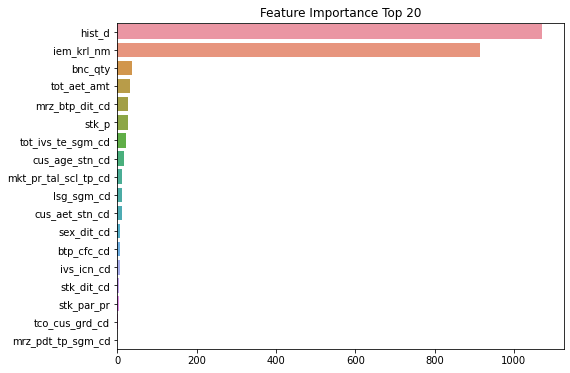

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['btp_cfc_cd', 'cus_aet_stn_cd', 'iem_krl_nm', 'ivs_icn_cd', 'lsg_sgm_cd', 'mkt_pr_tal_scl_tp_cd', 'mrz_btp_dit_cd', 'mrz_pdt_tp_sgm_cd', 'sex_dit_cd', 'stk_dit_cd', 'tco_cus_grd_cd']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 300 rounds.
Did not meet early stopping. Best iteration is:
[98]	valid_0's l2: 34.7502	valid_0's rmse: 5.89493


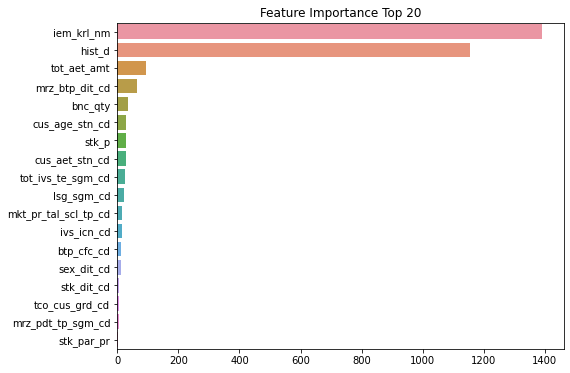

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['btp_cfc_cd', 'cus_aet_stn_cd', 'iem_krl_nm', 'ivs_icn_cd', 'lsg_sgm_cd', 'mkt_pr_tal_scl_tp_cd', 'mrz_btp_dit_cd', 'mrz_pdt_tp_sgm_cd', 'sex_dit_cd', 'stk_dit_cd', 'tco_cus_grd_cd']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 300 rounds.
Did not meet early stopping. Best iteration is:
[52]	valid_0's l2: 34.6887	valid_0's rmse: 5.88971


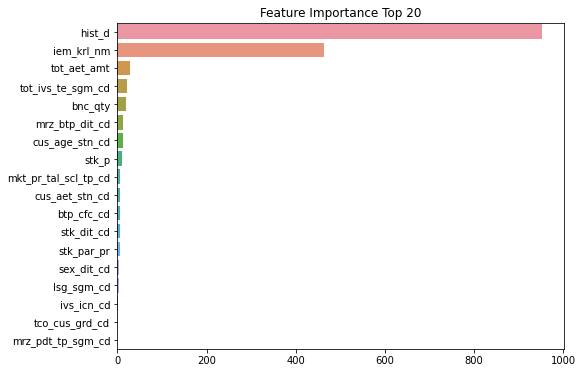

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['btp_cfc_cd', 'cus_aet_stn_cd', 'iem_krl_nm', 'ivs_icn_cd', 'lsg_sgm_cd', 'mkt_pr_tal_scl_tp_cd', 'mrz_btp_dit_cd', 'mrz_pdt_tp_sgm_cd', 'sex_dit_cd', 'stk_dit_cd', 'tco_cus_grd_cd']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 300 rounds.
Did not meet early stopping. Best iteration is:
[48]	valid_0's l2: 32.0151	valid_0's rmse: 5.65819


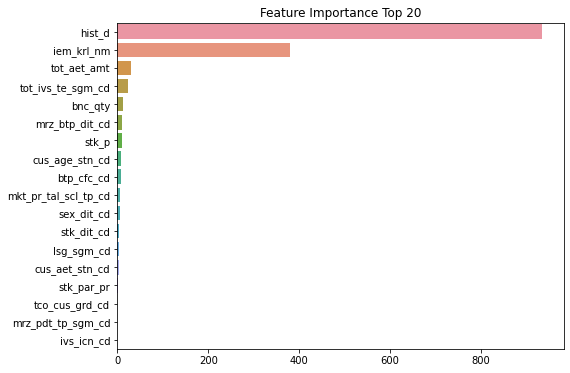

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['btp_cfc_cd', 'cus_aet_stn_cd', 'iem_krl_nm', 'ivs_icn_cd', 'lsg_sgm_cd', 'mkt_pr_tal_scl_tp_cd', 'mrz_btp_dit_cd', 'mrz_pdt_tp_sgm_cd', 'sex_dit_cd', 'stk_dit_cd', 'tco_cus_grd_cd']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 300 rounds.
Did not meet early stopping. Best iteration is:
[59]	valid_0's l2: 36.2892	valid_0's rmse: 6.02406


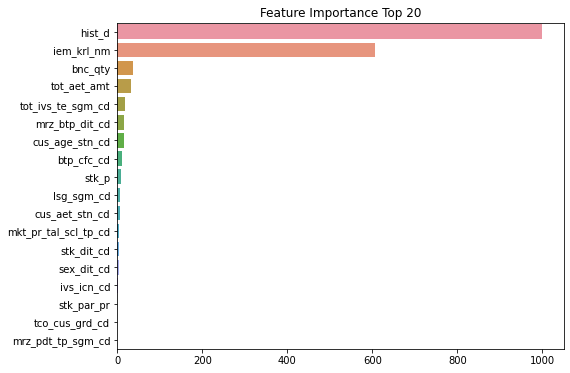

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['btp_cfc_cd', 'cus_aet_stn_cd', 'iem_krl_nm', 'ivs_icn_cd', 'lsg_sgm_cd', 'mkt_pr_tal_scl_tp_cd', 'mrz_btp_dit_cd', 'mrz_pdt_tp_sgm_cd', 'sex_dit_cd', 'stk_dit_cd', 'tco_cus_grd_cd']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 300 rounds.
Did not meet early stopping. Best iteration is:
[57]	valid_0's l2: 31.0979	valid_0's rmse: 5.57655


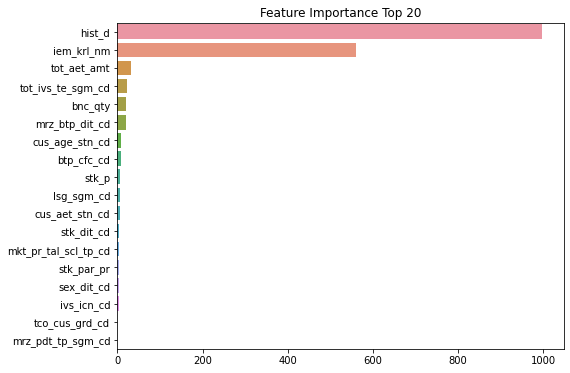

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['btp_cfc_cd', 'cus_aet_stn_cd', 'iem_krl_nm', 'ivs_icn_cd', 'lsg_sgm_cd', 'mkt_pr_tal_scl_tp_cd', 'mrz_btp_dit_cd', 'mrz_pdt_tp_sgm_cd', 'sex_dit_cd', 'stk_dit_cd', 'tco_cus_grd_cd']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 300 rounds.
Did not meet early stopping. Best iteration is:
[52]	valid_0's l2: 32.0048	valid_0's rmse: 5.65728


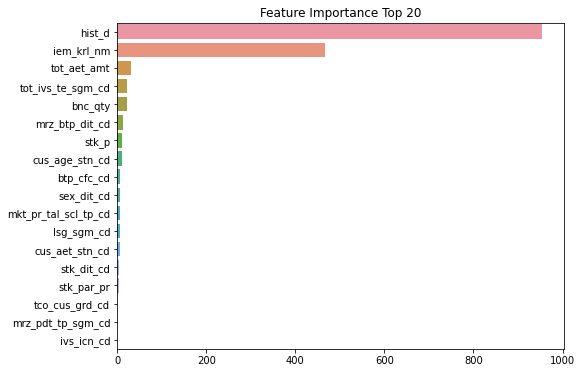

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['btp_cfc_cd', 'cus_aet_stn_cd', 'iem_krl_nm', 'ivs_icn_cd', 'lsg_sgm_cd', 'mkt_pr_tal_scl_tp_cd', 'mrz_btp_dit_cd', 'mrz_pdt_tp_sgm_cd', 'sex_dit_cd', 'stk_dit_cd', 'tco_cus_grd_cd']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 300 rounds.
Did not meet early stopping. Best iteration is:
[57]	valid_0's l2: 32.7026	valid_0's rmse: 5.71862


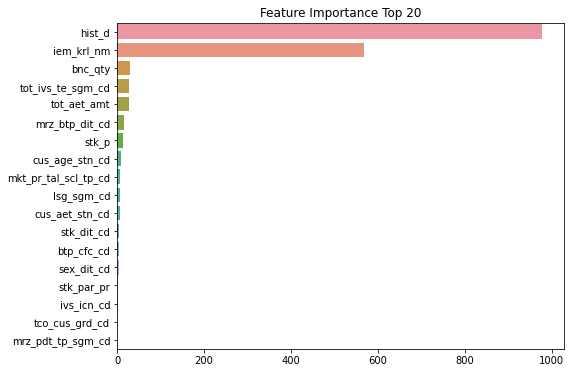

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['btp_cfc_cd', 'cus_aet_stn_cd', 'iem_krl_nm', 'ivs_icn_cd', 'lsg_sgm_cd', 'mkt_pr_tal_scl_tp_cd', 'mrz_btp_dit_cd', 'mrz_pdt_tp_sgm_cd', 'sex_dit_cd', 'stk_dit_cd', 'tco_cus_grd_cd']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 300 rounds.
Did not meet early stopping. Best iteration is:
[96]	valid_0's l2: 42.7809	valid_0's rmse: 6.54071


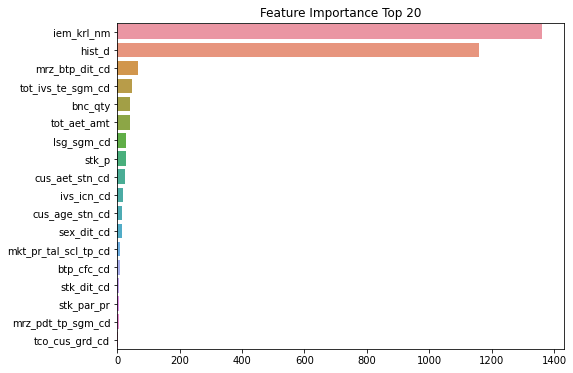

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['btp_cfc_cd', 'cus_aet_stn_cd', 'iem_krl_nm', 'ivs_icn_cd', 'lsg_sgm_cd', 'mkt_pr_tal_scl_tp_cd', 'mrz_btp_dit_cd', 'mrz_pdt_tp_sgm_cd', 'sex_dit_cd', 'stk_dit_cd', 'tco_cus_grd_cd']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 300 rounds.
Did not meet early stopping. Best iteration is:
[62]	valid_0's l2: 31.5827	valid_0's rmse: 5.61985


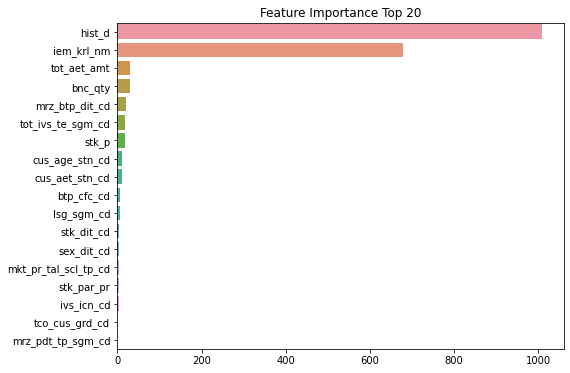

In [ ]:
models = []

folds = KFold(n_splits=10)
for train_idx, val_idx in folds.split(train_data):
    
    train_x = train_data.iloc[train_idx, :]
    train_y = train_label[train_idx]
    val_x = train_data.iloc[val_idx, :]
    val_y = train_label[val_idx]
    
    model = LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                          importance_type='split', learning_rate=0.1, max_depth=-1,
                          min_child_weight=0.001, min_split_gain=0.0,
                          n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
                          randon_state=123,reg_alpth=0.0, reg_lamda=0.0, silent=True,
                          subsample=0.9)
                    
        
    
    model.fit(train_x, train_y,
              eval_set=[(val_x, val_y)],
              eval_metric=["rmse"],
              early_stopping_rounds=300,
              verbose=500,
              categorical_feature = ['sex_dit_cd',	'ivs_icn_cd',	'cus_aet_stn_cd',	'mrz_pdt_tp_sgm_cd',	'lsg_sgm_cd',	'tco_cus_grd_cd',	'mrz_btp_dit_cd',	'iem_krl_nm',	'btp_cfc_cd',	'mkt_pr_tal_scl_tp_cd',	'stk_dit_cd'],
              feature_name = ['hist_d', 'sex_dit_cd', 'cus_age_stn_cd', 'ivs_icn_cd',
                              'cus_aet_stn_cd', 'mrz_pdt_tp_sgm_cd', 'lsg_sgm_cd', 'tco_cus_grd_cd',
                              'tot_ivs_te_sgm_cd', 'mrz_btp_dit_cd', 'iem_krl_nm', 'btp_cfc_cd',
                              'mkt_pr_tal_scl_tp_cd', 'stk_dit_cd', 'bnc_qty', 'tot_aet_amt',
                              'stk_par_pr', 'stk_p']
              )
    
    ft_importance_values = model.feature_importances_

    # 정렬과 시각화를 쉽게 하기 위해 series 전환
    ft_series = pd.Series(ft_importance_values, index = train_x.columns)
    ft_top20 = ft_series.sort_values(ascending=False)[:20]

    # 시각화
    plt.figure(figsize=(8,6))
    plt.title('Feature Importance Top 20')
    sns.barplot(x=ft_top20, y=ft_top20.index)
    plt.show()

    models.append(model)

In [ ]:
result = []
for i in models:
    result.append(i.predict(test_data))
predict = np.mean(result, axis = 0)

In [ ]:
predict

array([161.34151409, 342.83558921, 148.9065934 , ..., 775.31227373,
        18.24842813,   9.2475665 ])

In [ ]:
submission = pd.read_csv("/content/drive/MyDrive/공모전/주식 보유 기간 예측/sample_submission.csv")

In [ ]:
submission["hold_d"] = np.round(predict)

In [ ]:
submission.to_csv("dacon_주식 보유기간 예측_10.03(feature_추가 & 명목 변수 등록 & 수치형 데이터 스케일링 X & 고객 정보 X).csv", index = False)

### 내가 만든

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train,x_test, y_train, y_test = train_test_split(train_data, train_label, test_size=0.5, shuffle=True, random_state=42)

In [ ]:
from sklearn.datasets import load_boston
import xgboost
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import plot_importance

In [ ]:
xgb_model = xgboost.XGBRegressor(objective='reg:squarederror', estimators=400, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1,n_estimators=7, max_depth=15)

print(len(x_train), len(x_test))
xgb_model.fit(x_train,y_train)

15688 15689


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, estimators=400, gamma=0,
             importance_type='gain', learning_rate=0.08, max_delta_step=0,
             max_depth=15, min_child_weight=1, missing=None, n_estimators=7,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.75, verbosity=1)

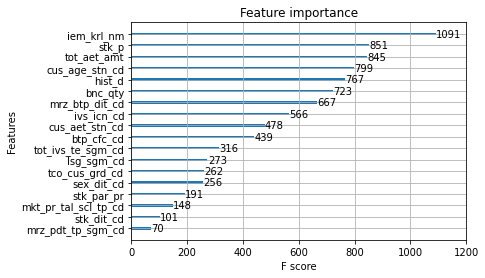

In [ ]:
import matplotlib.pyplot as plt
plot_importance(xgb_model)
plt.show()

In [ ]:
predictions = xgb_model.predict(x_test)
predictions=np.round(predictions)

In [ ]:
y_pred = xgb_model.predict(x_test)
y_true = y_test

mse = mean_squared_error(y_true, y_pred)
mse # 0.05036776284314333

7686.296423039946

In [ ]:
r_sq = xgb_model.score(x_train, y_train)
print(r_sq)
print(explained_variance_score(predictions,y_test))

0.4720292327718629
-0.8937942633551264


In [ ]:
submission = pd.read_csv("/content/drive/MyDrive/공모전/주식 보유 기간 예측/sample_submission.csv")

In [ ]:
submision_real = xgb_model.predict(test_data)

In [ ]:
submision_real

array([ 89.06526  , 172.91005  ,  82.22201  , ..., 311.21735  ,
        20.837921 ,   7.1138606], dtype=float32)

In [ ]:
submision_real=np.round(submision_real)

In [ ]:
submission["hold_d"] = submision_real

In [ ]:
submission.to_csv("dacon_주식 보유 예측_09.14_두번째.csv", index = False)

### regression

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(train_data, train_label, test_size=0.2, random_state=156)

In [ ]:
params = {'learning_rate': 0.01, 
          'max_depth': 16, 
          'boosting': 'gbdt', 
          'objective': 'regression', 
          'metric': 'mse', 
          'is_training_metric': True, 
          'num_leaves': 144, 
          'feature_fraction': 0.9, 
          'bagging_fraction': 0.7, 
          'bagging_freq': 5, 
          'seed':2018}

In [ ]:
from sklearn.model_selection import GridSearchCV

def get_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params, scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_train, y_train)
    rmse = np.sqrt(-1* grid_model.best_score_)
    print('최적 평균 RMSE 값:', np.round(rmse, 4))
    print('최적 파라미터:', grid_model.best_params_)
    
    return grid_model.best_estimator_

In [ ]:
from lightgbm import LGBMRegressor

# lgbm_params 값을 바꾸어주며 learning_rate, max_depth 등 파라미터 성능 비교 시도했었음.
lgbm_params = {'n_estimators':[3300]}

lgbm_reg = LGBMRegressor(n_estimators=3300, bagging_fraction=0.7, learning_rate=0.1,
                         max_depth=4, subsample=0.7, feature_fraction=0.9, boosting_type='gbdt',
                         colsample_bytree=0.5, reg_lambda=5, n_jobs=-1)

best_lgbm = get_best_params(lgbm_reg, lgbm_params)

최적 평균 RMSE 값: 5.9495
최적 파라미터: {'n_estimators': 3300}


In [ ]:
best_lgbm

LGBMRegressor(bagging_fraction=0.7, boosting_type='gbdt', class_weight=None,
              colsample_bytree=0.5, feature_fraction=0.9,
              importance_type='split', learning_rate=0.1, max_depth=4,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=3300, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=5, silent=True,
              subsample=0.7, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
from lightgbm import LGBMRegressor

# 위의 베스트 파라미터 사용
lgbm_reg = best_lgbm

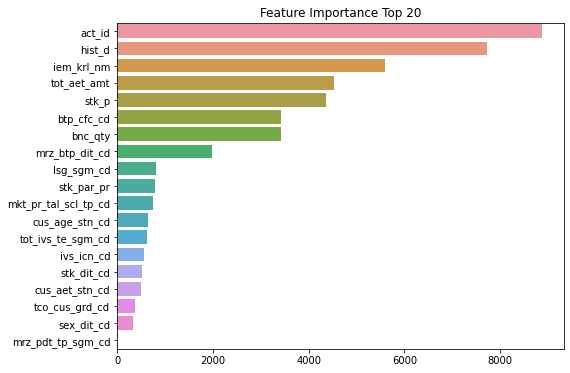

In [ ]:
lgbm_reg.fit(X_train, y_train)

ft_importance_values = lgbm_reg.feature_importances_

# 정렬과 시각화를 쉽게 하기 위해 series 전환
ft_series = pd.Series(ft_importance_values, index = X_train.columns)
ft_top20 = ft_series.sort_values(ascending=False)[:20]

# 시각화
plt.figure(figsize=(8,6))
plt.title('Feature Importance Top 20')
sns.barplot(x=ft_top20, y=ft_top20.index)
plt.show()

In [ ]:

lgbm_pred = lgbm_reg.predict(X_valid)

In [ ]:
from sklearn.metrics import mean_squared_error

lgbm_pred.astype(int)

RMSE = mean_squared_error(y_valid, lgbm_pred)**0.5

RMSE

5.924768716770077

In [ ]:
lgbm_pred = lgbm_reg.predict(test_data)

In [ ]:
lgbm_pred

array([161.40526116, 338.69676433, 147.75608931, ..., 778.82288992,
        17.87332533,   9.02789295])

In [ ]:
submission = pd.read_csv("/content/drive/MyDrive/공모전/주식 보유 기간 예측/sample_submission.csv")

In [ ]:
submission["hold_d"] = np.round(lgbm_pred)

In [ ]:
submission.to_csv("dacon_주식 보유기간 예측_10.03( data 추가 & 명목형 처리 ).csv", index = False)

In [ ]:
from lightgbm import LGBMRegressor

lgbm_reg = LGBMRegressor( num_iterations=1000, early_stopping_round=20, max_depth=-1, num_leaves=5,
                          n_estimators=3300, bagging_fraction=0.7, learning_rate=0.05,
                          subsample=0.7, feature_fraction=0.9, boosting_type='goss',
                          reg_lambda=5, n_jobs=-1)


31.68714740890674

### cross

In [ ]:
lgbm_reg = LGBMRegressor(n_estimators=3300, bagging_fraction=0.7, learning_rate=0.1,
                         max_depth=4, subsample=0.7, feature_fraction=0.9, boosting_type='gbdt',
                         colsample_bytree=0.5, reg_lambda=5, n_jobs=-1,
                         objective='regression', metric='rmse')

In [ ]:
from sklearn.model_selection import cross_validate

cross_validate(lgbm_reg,train_data,train_label, cv=10, scoring='neg_mean_squared_error', return_train_score=True)

{'fit_time': array([49.13591266, 48.95545006, 48.74292183, 48.7127552 , 48.5404911 ,
        49.80123711, 48.55390716, 48.76113415, 48.59635305, 48.31904435]),
 'score_time': array([9.58703828, 9.26069069, 9.26408744, 9.62792706, 8.81661582,
        9.23365068, 8.90258479, 8.94306564, 8.57870054, 8.84514689]),
 'test_score': array([-32.44019561, -36.8737093 , -38.32191828, -36.19697772,
        -32.5966054 , -36.33438204, -35.76356331, -35.05133698,
        -36.88047536, -34.4179028 ]),
 'train_score': array([-22.49436558, -22.42505169, -22.56537173, -22.54105653,
        -22.57967077, -22.43324176, -22.62249058, -22.58955301,
        -22.38932114, -22.60648126])}

In [ ]:
test_score=np.array([-32.44019561, -36.8737093 , -38.32191828, -36.19697772,
        -32.5966054 , -36.33438204, -35.76356331, -35.05133698,
        -36.88047536, -34.4179028 ])

In [ ]:
import math

a= -(test_score)


In [ ]:
a**(1/2)

array([5.69562952, 6.07237263, 6.19046996, 6.01639242, 5.70934369,
       6.02780076, 5.98026448, 5.92041696, 6.07292972, 5.86667732])

In [ ]:
math.sqrt(a)

TypeError: ignored

In [ ]:
from sklearn.model_selection import cross_validate

cross_validate(lgbm_reg,train_data,train_label, cv=10, scoring='neg_mean_squared_error', return_train_score=True)

{'fit_time': array([15.64386106, 15.58765197, 15.65114141, 15.59071684, 15.54197884,
        15.38725519, 15.46836138, 15.35064912, 15.33629227, 15.15312624]),
 'score_time': array([2.08265448, 2.19481134, 2.22138095, 2.28347945, 2.35322833,
        2.1408093 , 2.26626539, 2.27648926, 2.16974068, 1.99568439]),
 'test_score': array([-985.847837  , -950.5077312 , -933.18373641, -924.09100684,
        -966.67856903, -954.96813904, -925.89403739, -949.93932521,
        -906.65754344, -930.31812927]),
 'train_score': array([-450.73303946, -457.20556776, -455.45328105, -460.11446209,
        -455.37766318, -465.47629819, -459.14626764, -461.32144537,
        -461.16726181, -461.50600361])}

In [ ]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [ ]:
test_data

,act_id,iem_krl_nm,hist_d,mrz_btp_dit_cd,수익률,bnc_qty,tot_aet_amt
0,399,418,5.036953,8,-0.093606,5.707110,0.919525
1,399,2230,5.817111,8,-2.503357,5.293305,0.689538
2,399,1515,4.941642,8,0.384285,4.934474,0.962934
3,399,2681,5.468060,8,-0.479265,7.997327,1.193687
4,399,2450,2.302585,8,0.174687,2.397895,-0.182606
...,...,...,...,...,...,...,...
70591,3310,1369,3.178054,2,0.047915,0.693147,-0.620611
70592,3310,444,4.644391,2,0.693405,3.931826,-0.297015
70593,2678,1280,6.755769,8,NaN,11.226016,0.883391
70594,2678,2373,2.484907,8,0.399566,4.574711,1.467317


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and wil

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51061 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47456 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51061 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 47456 missing from current font.
  font.set_text

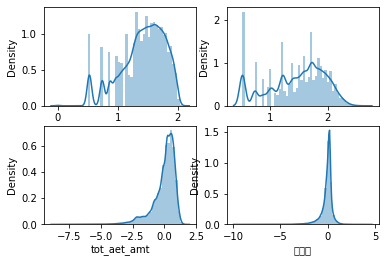

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.subplot(221)
sns.distplot(np.log1p(train_data['hist_d']))

plt.subplot(222)
sns.distplot(np.log1p(train_data['bnc_qty']))

plt.subplot(223)
sns.distplot(np.log1p(train_data['tot_aet_amt']))

plt.subplot(224)
sns.distplot(np.log1p(train_data['수익률']))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and wil

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51061 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47456 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51061 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 47456 missing from current font.
  font.set_text

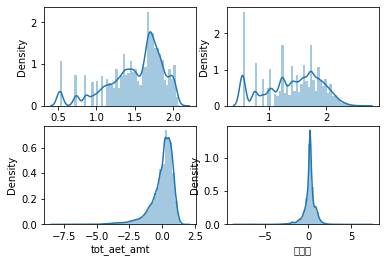

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.subplot(221)
sns.distplot(np.log1p(test_data['hist_d']))

plt.subplot(222)
sns.distplot(np.log1p(test_data['bnc_qty']))

plt.subplot(223)
sns.distplot(np.log1p(test_data['tot_aet_amt']))

plt.subplot(224)
sns.distplot(np.log1p(test_data['수익률']))